# Практическое задание по модулю ML-7. Оптимизация гиперпараметров модели

### **Цель**: Необходимо предсказать биологический ответ молекул (столбец '`Activity`') по их химическому составу (столбцы `D1-D1776`).

### **Метрика**: `F1-score`

### **Задач**а: Необходимо обучить **две модели**: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (`GridSeachCV`, `RandomizedSearchCV`, `Hyperopt`, `Optuna`) хотя бы по разу, максимальное количество итераций не должно превышать `50`.

###  Содержание <a class="anchor" id=0></a>
- [1. Модели без оптимизации](#1)
- [1.1 Логическая регрессия](#1)
- [1.2 Случайный лес](#1-2)
- [2. Оптимизация моделей](#2)
- [2.1. GridSearchCV](#2)
- [2.2. RandomizedSearchCV](#2-2)
- [2.3. Hyperopt](#2-3)
- [2.4. Optuna](#2-4)
- [3. Итоги](#3)


## Импортируем всякое полезное

In [1]:
import numpy as np
import pandas as pd 
from sklearn import linear_model 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import model_selection 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
plt.style.use('seaborn')

## Прочтём данные

In [2]:
data = pd.read_csv('train.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## Данные предобработаны, но `trust no one` или "доверяй, но проверяй"

In [3]:
print('Пропуски в данных: {}'.format(data.isna().any().any()))
print('Дубликаты в данных: {}'.format(data.duplicated().any()))
print('Данные больше |1|: {}'.format((data > abs(1)).any().any()))

Пропуски в данных: False
Дубликаты в данных: False
Данные больше |1|: False


## Проверим сбалансированы ли данные по искомому признаку

In [4]:
print(data['Activity'].value_counts())
print('Соотношение 0 к 1 по признаку "Activity": {:.2f}%' .format(data['Activity'].value_counts()[0] / data['Activity'].value_counts()[1] * 100))

1    2034
0    1717
Name: Activity, dtype: int64
Соотношение 0 к 1 по признаку "Activity": 84.41%


## Произведём разбивку с учётом несбалансированности данных

In [5]:
X = data.drop('Activity', axis=1)
y = data['Activity']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(2625, 1776) (1126, 1776) (2625,) (1126,)


# 1. Модели без оптимизаций <a class="anchor" id=1></a>

[наверх](#0)

## 1.1 Логическая регрессия 

In [6]:
# Создаём модель
lr = linear_model.LogisticRegression(
    max_iter=1000,
    random_state=42
)
# Обучаем модель
lr.fit(X_train, y_train)

# Делаем предсказания
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Посчитаем метрику
print('f1_score на тренировочном наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тренировочном наборе: 0.901
f1_score на тестовом наборе: 0.780


## 1.2 Логическая регрессия с кросс-валидацией

In [7]:
# Создаём объект кросс-валидации
kf = model_selection.KFold(n_splits=5)

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=lr,
    X=X,
    y=y,
    cv=kf,
    scoring='f1',
    return_train_score=True 
)

print('f1_score_mean на тренировочном наборе с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['train_score'])))
print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score_mean на тренировочном наборе с кросс-валидацией: 0.891
f1_score_mean на тестовом наборе с кросс-валидацией: 0.778


## 1.3 Случайный лес <a class="anchor" id=1-2></a>

[наверх](#0)

In [8]:
# Создаём модель
rf = ensemble.RandomForestClassifier(
    random_state=42
)

# Обучаем модель и снимаем метрику
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
print('f1_score на тренировочном наборе: {:.3f}'.format(metrics.f1_score(y_train_pred, y_train)))
y_test_pred = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test_pred, y_test)))

f1_score на тренировочном наборе: 1.000
f1_score на тестовом наборе: 0.793


## 1.3 Случайный лес с кросс-валидацией

In [39]:
# Создаём объект кросс-валидации
kf = model_selection.KFold(n_splits=5)

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=rf,
    X=X,
    y=y,
    cv=kf,
    scoring='f1',
    return_train_score=True 
)

print('f1_score_mean на тренировочном наборе с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['train_score'])))
print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score_mean на тренировочном наборе с кросс-валидацией: 0.983
f1_score_mean с кросс-валидацией: 0.817


# 2. Оптимизиция моделей <a class="anchor" id=2></a>

[наверх](#0)

## 2.1 GridSearchCV

## 2.1.1 GS_lr

# Во всех примерах оставил минимальное количество параметров для перебора с целью ускорения работы кода. За скобками оставил многочисленные прогоны моделей для минимизации пространства для переборов гиперпараметров.

In [10]:
# Задаём сетку параметров для перебора
param_grid = {'penalty': ['l2'],
              'solver': ['lbfgs','sag'],
              'C': [0.1, 0.2, 0.3]
              }
# Запускаем GridSearchCV для перебора заданных параметров
grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search_lr.fit(X_train, y_train) 

# Делаем предсказания и снимаем метрики на лучших из найденных параметрах
y_test_pred = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
f1_score на тестовом наборе: 0.789
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


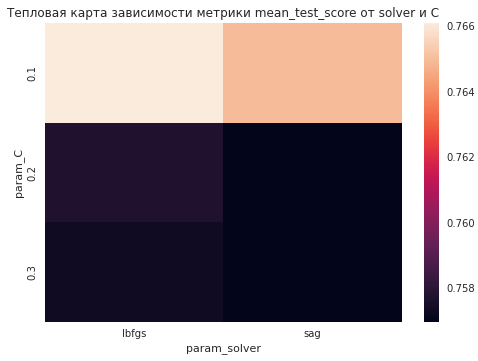

In [11]:
# Визуализируем как менялась точность при различных гиперпараметрах
result_cv_lr = pd.DataFrame(grid_search_lr.cv_results_)
visual = pd.pivot_table(pd.DataFrame(grid_search_lr.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики mean_test_score от solver и С') 
sns.set(rc={'figure.figsize':(12, 8)}) 

## 2.1.2 GS_rf 

[наверх](#0)

In [12]:
# Задаём сетку параметров для перебора
param_grid = {'min_samples_leaf':[3, 5],
               'n_estimators': [240, 250, 260], 
               'criterion': ['entropy', 'gini']}

# Запускаем GridSearchCV для перебора заданных параметров
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time 
grid_search_rf.fit(X_train, y_train) 

# Делаем предсказания и снимаем метрики на лучших из найденных параметрах
y_test_pred = grid_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 7.87 µs
f1_score на тестовом наборе: 0.809
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'min_samples_leaf': 3, 'n_estimators': 250}


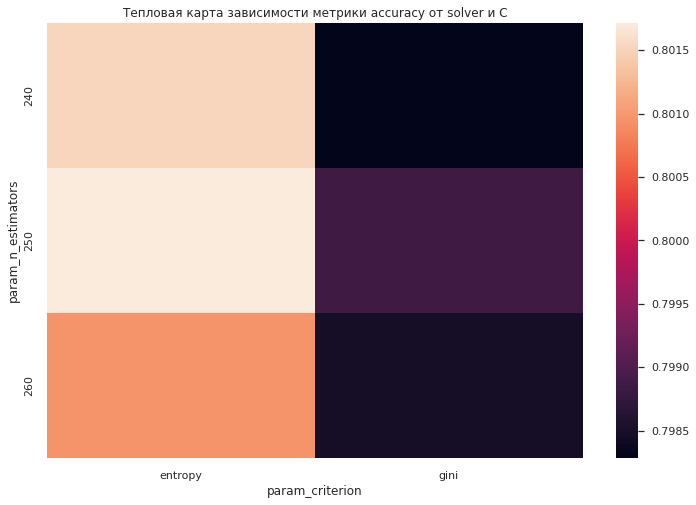

In [13]:
# Визуализируем как менялась точность при различных гиперпараметрах
result_cv = pd.DataFrame(grid_search_rf.cv_results_)
visual = pd.pivot_table(pd.DataFrame(grid_search_rf.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_criterion')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

# 2.2 RandomizedSearchCV <a class="anchor" id=2-2></a>

[наверх](#0)

## 2.2.1 RS_lr

In [14]:
# Задаём сетку параметров для перебора
param_grid = {'penalty': ['l2'],
              'solver': ['lbfgs','sag'],
              'C': [0.1, 0.2, 0.3]
              }

# Запускаем RandomizedSearchCV для перебора заданных параметров
random_search_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid,
    cv=5,
    n_iter=20,
    n_jobs=-1
)
%time 
random_search_lr.fit(X_train, y_train) 

# Делаем предсказания и снимаем метрики на лучших из найденных параметрах
y_test_pred = random_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs


/home/aubakirov/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=20. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


f1_score на тестовом наборе: 0.789
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}


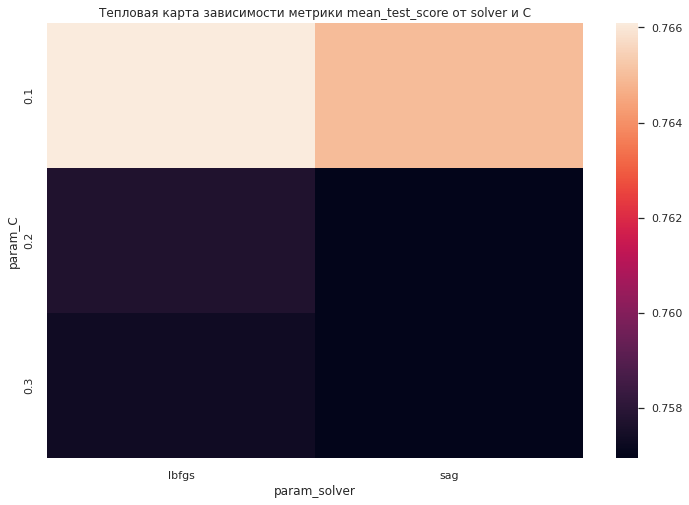

In [15]:
# Визуализируем как менялась точность при различных гиперпараметрах
result_cv_lr = pd.DataFrame(random_search_lr.cv_results_)
visual = pd.pivot_table(pd.DataFrame(random_search_lr.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики mean_test_score от solver и С') 
sns.set(rc={'figure.figsize':(12, 8)}) 

## 2.2.2 RS_rf 

[к наверх](#0)

In [16]:
# Задаём сетку параметров для перебора
param_grid = {'min_samples_leaf':[3, 5],
               'n_estimators': [240, 250, 260], 
               'criterion': ['entropy', 'gini']}

# Запускаем RandomizedSearchCV для перебора заданных параметров
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    cv=5,
    n_iter=20,
    n_jobs=-1
)
%time 
random_search_rf.fit(X_train, y_train) 

# Делаем предсказания и снимаем метрики на лучших из найденных параметрах
y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))


CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs


/home/aubakirov/.local/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


f1_score на тестовом наборе: 0.809
Наилучшие значения гиперпараметров: {'n_estimators': 250, 'min_samples_leaf': 3, 'criterion': 'entropy'}


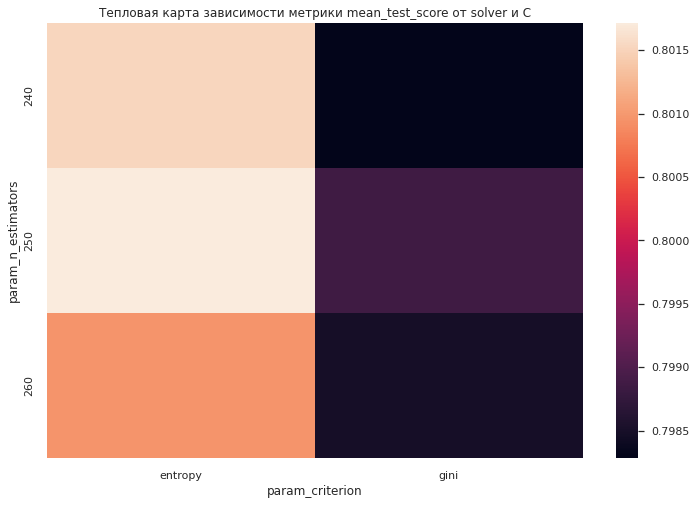

In [17]:
# Визуализируем как менялась точность при различных гиперпараметрах
result_cv_lr = pd.DataFrame(random_search_rf.cv_results_)
visual = pd.pivot_table(pd.DataFrame(random_search_rf.cv_results_),
                        values='mean_test_score', index='param_n_estimators',
                        columns='param_criterion')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики mean_test_score от solver и С') 
sns.set(rc={'figure.figsize':(12, 8)}) 

# 2.3 Hyperopt <a class="anchor" id=2-3></a>

[наверх](#0)

## 2.3.1 HP_lr не смог решить проблему с возвратом от Hyperopt лучших найденных параметров переданных в форме "слов" функция возвращает их индексами при этом непонятно к чему можно обратиться по этому индексу чтобы обратно получить "слово". Всякие переустановки Hyperopt и прочие "полезные" советы из Slack'а не помогли.

## 2.3.2 HP_rf

In [18]:
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [19]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)

    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [20]:
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 10/10 [01:12<00:00,  7.21s/trial, best loss: -0.824292109099203]
Наилучшие значения гиперпараметров {'min_samples_leaf': 3.0, 'n_estimators': 402.0}


In [37]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=kf,
    scoring='f1',
    return_train_score=True 
)

print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score на тестовом наборе: 0.800
f1_score_mean с кросс-валидацией: 0.812


# 2.4 Optuna <a class="anchor" id=2-4></a>

[наверх](#0)

In [34]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 1)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)

  # создаем модель
  model_op = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model_op.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [23]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-12-31 11:47:51,160] A new study created in memory with name: RandomForestClassifier
[I 2022-12-31 11:47:58,266] Trial 0 finished with value: 0.9905163329820864 and parameters: {'n_estimators': 477, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9905163329820864.
[I 2022-12-31 11:48:03,951] Trial 1 finished with value: 0.9769874476987448 and parameters: {'n_estimators': 451, 'max_depth': 43, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9905163329820864.
[I 2022-12-31 11:48:09,812] Trial 2 finished with value: 0.9664570230607966 and parameters: {'n_estimators': 490, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9905163329820864.
[I 2022-12-31 11:48:14,309] Trial 3 finished with value: 0.936214708957825 and parameters: {'n_estimators': 429, 'max_depth': 12, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9905163329820864.
[I 2022-12-31 11:48:18,274] Trial 4 finished with value: 0.9413398125650816 and parameters: {'n_e

CPU times: user 1min 16s, sys: 283 ms, total: 1min 17s
Wall time: 1min 17s


In [24]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 275, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [35]:
# рассчитаем точность для тестовой выборки
model_op = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model_op.fit(X_train, y_train)

y_test_pred = model_op.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.800


In [26]:
study.optimize(optuna_rf, n_trials=10)

[I 2022-12-31 11:49:16,557] Trial 20 finished with value: 0.9905163329820864 and parameters: {'n_estimators': 336, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 18 with value: 0.9912126537785588.
[I 2022-12-31 11:49:20,886] Trial 21 finished with value: 0.9908643710470836 and parameters: {'n_estimators': 335, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 18 with value: 0.9912126537785588.
[I 2022-12-31 11:49:25,123] Trial 22 finished with value: 0.9901685393258427 and parameters: {'n_estimators': 328, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 18 with value: 0.9912126537785588.
[I 2022-12-31 11:49:30,143] Trial 23 finished with value: 0.9905229905229905 and parameters: {'n_estimators': 393, 'max_depth': 31, 'min_samples_leaf': 2}. Best is trial 18 with value: 0.9912126537785588.
[I 2022-12-31 11:49:34,971] Trial 24 finished with value: 0.9772965420887182 and parameters: {'n_estimators': 387, 'max_depth': 31, 'min_samples_leaf': 3}. Best is trial 18 with va

In [36]:
# рассчитаем точность для тестовой выборки
model_op = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model_op.fit(X_train, y_train)

y_test_pred = model_op.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=model_op,
    X=X,
    y=y,
    cv=kf,
    scoring='f1',
    return_train_score=True 
)

print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score на тестовом наборе: 0.800
f1_score_mean с кросс-валидацией: 0.813


In [28]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

# 3. Итоги <a class="anchor" id=3></a>

[наверх](#0)

По полученным гиперпараметрам обучим финальные версии моделей.

## Логическая регрессия

In [40]:
# Создаём модель с подобранными гиперпараметрами
lr = linear_model.LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',
    penalty='l2',
    C=0.1
)

# Создаём объект кросс-валидации
kf = model_selection.KFold(n_splits=5)

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=lr,
    X=X,
    y=y,
    cv=kf,
    scoring='f1'
)

print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score_mean с кросс-валидацией: 0.789


## Случайный лес

In [41]:
# Создаём модель с подобранными гиперпараметрами
rf = ensemble.RandomForestClassifier(
    random_state=42,
    n_estimators=250,
    min_samples_leaf=3,
    criterion='entropy'
)

# Создаём объект кросс-валидации
kf = model_selection.KFold(n_splits=5)

# Считаем метрику на кросс-валидации
cv_metrics = model_selection.cross_validate(
    estimator=rf,
    X=X,
    y=y,
    cv=kf,
    scoring='f1'
)

print('f1_score_mean с кросс-валидацией: {:.3f}'.format(np.mean(cv_metrics['test_score'])))

f1_score_mean с кросс-валидацией: 0.817
